# Assignment 4. Deep Learning

*Foundations of Data Science*  
*Dr. Khalaj (Fall 2023)*  

*For questions 2-4 refer to @alregamo on Telegram.*

### Description  
This homework consists of four questions, each aimed at one category in the world of Deep Learning.   
1. Getting familiarized with sentiment analysis (A subject also covered in the course project).
   
2. Multi-layer perceptron (MLP). 
   
3. Convolutional Neural Networks (CNN).
   
4. Variational Autoencoders (VAE).

### Information  
Complete the information box below.

In [49]:
full_name = 'Ilia Hashemi Rad'
student_id = '99102456'

### Note
The questions are not necessarily in order of difficulty. You are obligated to answer **3 out of 4** questions. The fourth question is optional and is considered as bonus.

## 2 Multi-layer Perceptron (MLP)

**In this assignment you'll be working with Dorothea Dataset.**

DOROTHEA is a drug discovery dataset. Chemical compounds represented by structural molecular features must be classified as active (binding to thrombin) or inactive. To find out more about dataset, refer to this link: https://archive.ics.uci.edu/ml/datasets/Dorothea

You should implement a classifier with Neural Networks and for this purpose we will be using PyTorch as framework.

### 2.1 Importing libraries, modules and Dataset.

In this part, import all the libraries and modules needed to solve the problem.

In [50]:
import os
import random 
import torch 
import torch.nn as nn
import numpy as np

Now import the train and test data from dataset.

In [51]:
def read_sparse(file_path , rows, cols):
  matrix =np.zeros((rows, cols), dtype = int)
  with open (file_path , 'r') as file:
    for row_idx, line in enumerate(file):
      column_indices = map(int, line.split())
      matrix[row_idx , np.array(list(column_indices))-1] = 1
      return matrix


n_features = 100000
train_count, test_count = 800, 350

train_data = read_sparse('/kaggle/input/dorothea/dorothea_train.data', train_count, n_features)
train_labels = np.genfromtxt('/kaggle/input/dorothea/dorothea_train.labels')
test_data = read_sparse('/kaggle/input/dorothea/dorothea_valid.data', test_count, n_features)
test_labels = np.genfromtxt('/kaggle/input/dorothea/dorothea_valid.labels')

# Convert the -1 values to 0
train_labels[train_labels==-1] = 0
test_labels[test_labels==-1] = 0

#### Balancing the dataset by replicating the rare labels (one values)

### 2.2 Normalize
You can normalize your data using <code>Scikit-Learn</code> modules here.

In [52]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler

# Convert to CSR matrix if not already in CSR format
sparse_matrix_csr = csr_matrix(train_data)

# Normalize the CSR matrix
normalized_sparse_matrix = normalize(sparse_matrix_csr, norm='l2', axis=1)

# 'l2' normalization scales each row to have a Euclidean norm of 1
train_data_normalized = normalized_sparse_matrix.toarray()

# Convert to CSR matrix if not already in CSR format
sparse_matrix_csr = csr_matrix(test_data)

# Normalize the CSR matrix
normalized_sparse_matrix = normalize(sparse_matrix_csr, norm='l2', axis=1)

# 'l2' normalization scales each row to have a Euclidean norm of 1
test_data_normalized = normalized_sparse_matrix.toarray()


### 2.3 Dimensionality Reduction
There are too many attributes for each instance of dataset. We will suffer from sparse data and long training phase. Thus you can reduce dimensions to get better accuracy. 

Principal component analysis (PCA) is the process of computing the principal components and using them to perform a change of basis on the data.

Apply PCA on Dorothea dataSet using <code>Scikit-Learn</code>.

In [53]:
# Apply PCA
n_components = 256 
pca = PCA(n_components=n_components)
train_data_pca = pca.fit_transform(train_data_normalized)
test_data_pca = pca.transform(test_data_normalized)

# The resulting 'train_data_pca' is now a ndarray with reduced dimensionality
print("Original shape:", train_data.shape)
print("Shape after PCA:", train_data_pca.shape)

Original shape: (800, 100000)
Shape after PCA: (800, 256)


### 2.4 Define Model



In [54]:
import torch
import torch.nn as nn

# Define a simple MLP model
class MLPModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 32)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(32, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

### 2.5 Train the model

**Initialize model, define hyperparameters, optimizer, loss function, etc.**



In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Convert NumPy arrays to PyTorch tensors
train_data_tensor = torch.Tensor(train_data_pca).float()
train_labels_tensor = torch.Tensor(train_labels).float()

# Define a custom dataset
dataset = TensorDataset(train_data_tensor, train_labels_tensor)

# Define DataLoader for batching
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Set model hyperparameters
input_size = train_data_pca.shape[1]  # Assuming the input size is the number of PCA components
output_size = 1  # Binary classification

# Instantiate the model
model = MLPModel(input_size, output_size)

# Create an instance of the BCEWithLogitsLoss function with pos_weight
pos_weight = torch.tensor ([722/78]) # calculate the weight for the positive class
criterion = nn.BCEWithLogitsLoss (pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training loop
epochs = 20

loss_function_values = []
for epoch in range(epochs):
    train_loss = 0
    for inputs, labels in dataloader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # accumulate the training loss
        train_loss += loss.item()
        
    # compute the average training loss and accuracy
    train_loss = train_loss / len(dataloader)
    
    loss_function_values.append(train_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss}')

Epoch 1/20, Loss: 0.8991825167949383
Epoch 2/20, Loss: 0.8854548518474286
Epoch 3/20, Loss: 0.8703206685873178
Epoch 4/20, Loss: 0.8441970531757061
Epoch 5/20, Loss: 0.8014838282878582
Epoch 6/20, Loss: 0.7445823779472938
Epoch 7/20, Loss: 0.6914806411816523
Epoch 8/20, Loss: 0.661565702695113
Epoch 9/20, Loss: 0.6411282328458933
Epoch 10/20, Loss: 0.6334613469930795
Epoch 11/20, Loss: 0.6313517001958994
Epoch 12/20, Loss: 0.6309252381324768
Epoch 13/20, Loss: 0.6304050042079046
Epoch 14/20, Loss: 0.6286426736758306
Epoch 15/20, Loss: 0.6296919263326205
Epoch 16/20, Loss: 0.6251089939704308
Epoch 17/20, Loss: 0.6265037105633662
Epoch 18/20, Loss: 0.6238164351536677
Epoch 19/20, Loss: 0.6261866551179153
Epoch 20/20, Loss: 0.6260919800171485


**After the training process, plot metrics such as loss function values.**

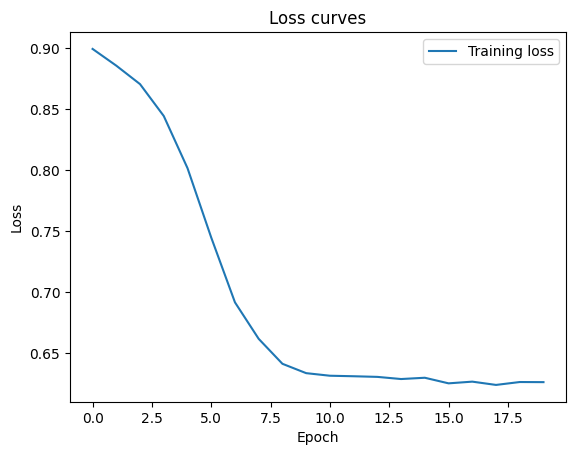

In [86]:
# Plot in here
import matplotlib.pyplot as plt

# Plot the loss curves
plt.plot(loss_function_values, label='Training loss')
plt.title('Loss curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.6 Testing
After training, test your model on test dataset and compute performance metrics. 

In [87]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the accuracy, precision, recall, and F1-score
accuracy = accuracy_score (test_labels, test_preds)
precision = precision_score (test_labels, test_preds)
recall = recall_score (test_labels, test_preds)
f1 = f1_score (test_labels, test_preds)

# Print the metrics
print (f'Accuracy: {accuracy}')
print (f'Precision: {precision}')
print (f'Recall: {recall}')
print (f'F1-score: {f1}')


Accuracy: 0.9485714285714286
Precision: 0.6428571428571429
Recall: 0.6923076923076923
F1-score: 0.6666666666666666


Show confusion matrix of your model.

In [89]:
# Print your confusion matrix here.
# Import libraries
import numpy as np
from sklearn.metrics import confusion_matrix

# Create the test data and labels as tensors
test_data = torch.from_numpy (test_data_pca).float () # use the PCA-transformed data
test_labels = torch.from_numpy (test_labels).float () # use the binary labels

# Predict the labels using the model
test_outputs = model (test_data)
test_preds = torch.round (torch.sigmoid (test_outputs)) # apply the sigmoid function and round to 0 or 1

# Convert the tensors to numpy arrays
test_preds = test_preds.detach ().numpy ()
test_labels = test_labels.numpy ()

# Calculate the confusion matrix
cm = confusion_matrix (test_labels, test_preds)

# Print the confusion matrix
print (cm)

[[314  10]
 [  8  18]]
